# 隐马尔可夫模型

用Python实现隐马尔科夫模型。

In [1]:
import numpy as np
import pandas as pd
from hmmlearn import hmm
import matplotlib.pyplot as plt

In [2]:
def generate_sample_data(
    n_samples: int = 1000, random_state: int = 38
) -> tuple[np.ndarray, np.ndarray, list[int]]:
    """生成模拟数据"""
    # 设置随机种子
    np.random.seed(random_state)

    # 定义两种状态的参数
    # 状态1：趋势（高收益，高波动）
    # 状态2：震荡（低收益，低波动）
    means = [0.002, 0.0001]  # 两种状态的平均收益率
    stds = [0.03, 0.01]  # 两种状态的标准差

    # 初始化数据
    returns = []
    true_states = []
    current_state = 0  # 从状态1开始

    # 状态转移概率
    # 状态1用0表示，保持在状态1的概率为0.95，转移到状态2的概率为0.05
    # 状态2用1表示，保持在状态2的概率为0.95，转移到状态1的概率为0.05
    transition_probs = {0: 0.95, 1: 0.95}

    # 生成数据
    for _ in range(n_samples):
        # 生成收益率
        returns.append(np.random.normal(means[current_state], stds[current_state]))
        true_states.append(current_state)

        # 状态转换
        if np.random.random() > transition_probs[current_state]:
            current_state = 1 - current_state  # 切换状态

    returns = np.array(returns)

    # 生成价格序列
    prices = 100 * np.exp(np.cumsum(returns))

    return returns, prices, true_states

In [3]:
returns, prices, true_states = generate_sample_data(1000, 123)

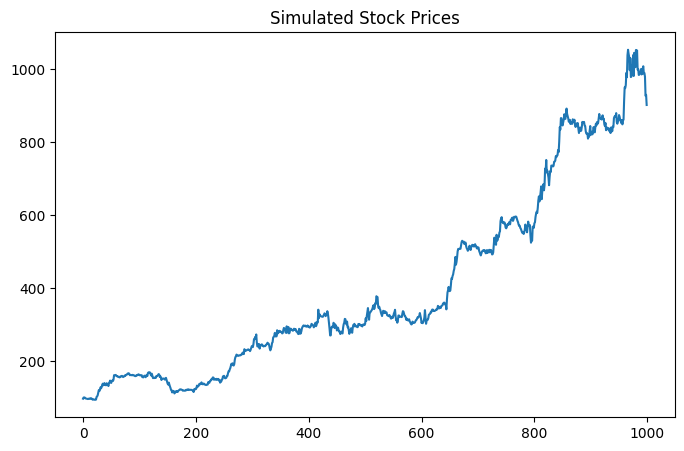

In [4]:
plt.figure(figsize=(8, 5))
plt.plot(prices)
_ = plt.title("Simulated Stock Prices")

实现HMM模型。

`hmm.GaussianHMM`参数：

- n_components: 隐藏状态的数量，根据业务逻辑选择数量，数量越多模型越复杂，过拟合风险越大，建议从2-3个状态开始
- covariance_type: 协方差类型，默认"diag"
    - "full"：完全协方差矩阵
    - "diag"：对角协方差矩阵
    - "spherical"：球面协方差
    - "tied"：所有状态共享一个协方差矩阵
    - 使用建议：
        - "diag"最常用，计算效率高
        - 如果特征之间相关性强，可以使用"full"
        - "spherical"最简单但限制最大
- n_iter: 最大迭代次数，设置较大的值（如1000）确保收敛，配合tol参数使用
- random_state: 随机种子，确保结果可重复，建议始终设置固定值以确保实验的可重复性
- tol: 收敛阈值，通常默认值足够
- verbose: 是否打印训练信息
- init_params: 初始化参数类型

In [5]:
# 指定状态数量
n_states = 2

# 初始化HMM模型
model = hmm.GaussianHMM(
    n_components=n_states, covariance_type="diag", n_iter=1000, random_state=123
)

# 调整数据形状，模型要求输入数据是m*n的矩阵，m是样本数量，n是特征数量
X = returns.reshape(-1, 1)

# 训练模型
model.fit(X)

# 预测状态
hidden_states = model.predict(X)

可视化结果。

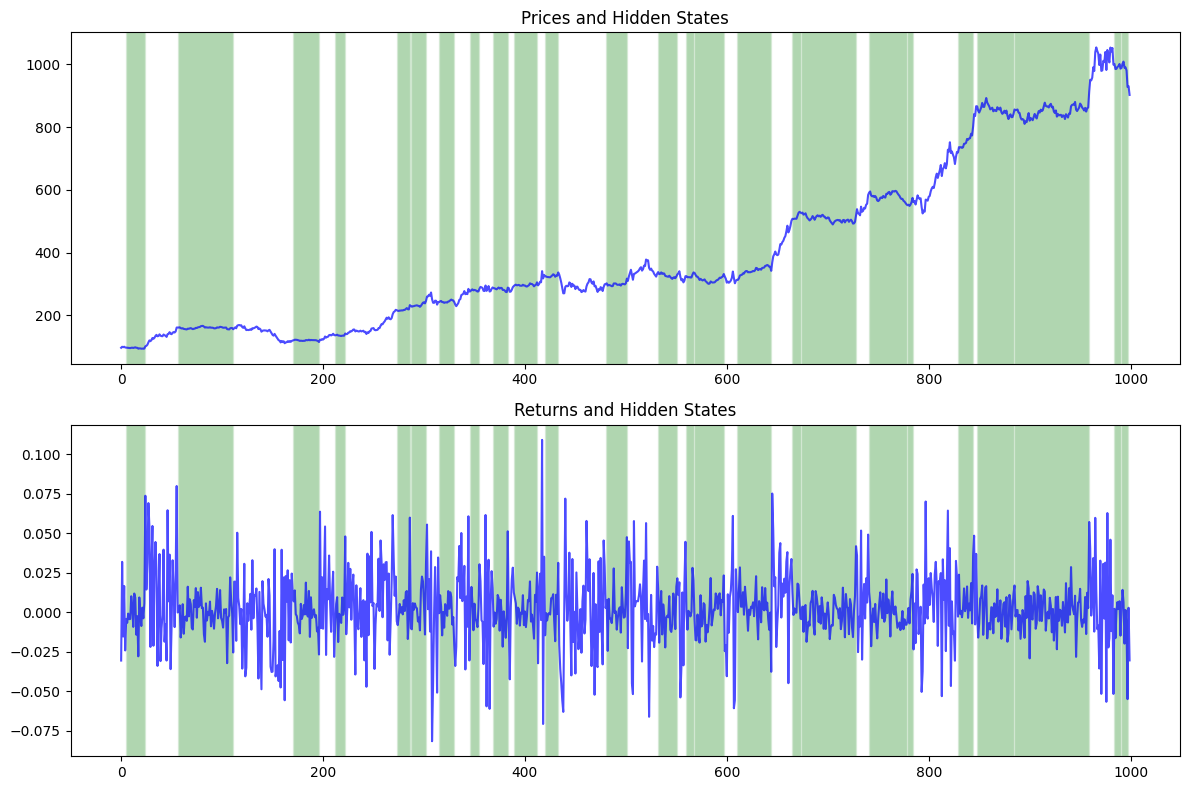

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# 绘制价格和推断状态
ax1.plot(prices, color="blue", alpha=0.7)
ax1.set_title("Prices and Hidden States")

for i in range(len(prices)):
    if hidden_states[i] == 0:  # 状态1（趋势）
        ax1.axvspan(i, i + 1, color="green", alpha=0.1)

# 绘制收益率和隐藏状态
ax2.plot(returns, color="blue", alpha=0.7)
ax2.set_title("Returns and Hidden States")

for i in range(len(returns)):
    if hidden_states[i] == 0:  # 状态1（趋势）
        ax2.axvspan(i, i + 1, color="green", alpha=0.1)

plt.tight_layout()